In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank
from src.codes_q import create_bivariate_bicycle_codes, create_circulant_matrix
from src.build_circuit import build_circuit, dem_to_check_matrices
from src import bpgdg_decoder

hard_samples = []

1.13.dev1701377008


In [2]:
decoding_time = []
def sliding_window_decoder(N, p=0.003, num_repeat=12, num_shots=10000, max_iter=200, W=3, F=1, z_basis=True, 
                           noisy_prior=None, method=1, plot=False, low_error_mode=False,
                           max_step=25, max_iter_per_step=6, max_tree_depth=3, max_side_depth=10, max_side_branch_step=10,
                           last_win_gdg_factor=1.0, last_win_bp_factor=1.0):
    
    if N == 72:
        code, A_list, B_list = create_bivariate_bicycle_codes(6, 6, [3], [1,2], [1,2], [3]) # 72
    elif N == 90:
        code, A_list, B_list = create_bivariate_bicycle_codes(15, 3, [9], [1,2], [2,7], [0]) # 90
    elif N == 108:
        code, A_list, B_list = create_bivariate_bicycle_codes(9, 6, [3], [1,2], [1,2], [3]) # 108
    elif N == 144:
        code, A_list, B_list = create_bivariate_bicycle_codes(12, 6, [3], [1,2], [1,2], [3]) # 144
    elif N == 288:
        code, A_list, B_list = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3]) # 288
    elif N == 360:
        code, A_list, B_list = create_bivariate_bicycle_codes(30, 6, [9], [1,2], [25,26], [3]) # 360
    elif N == 756:
        code, A_list, B_list = create_bivariate_bicycle_codes(21,18, [3], [10,17], [3,19], [5]) # 756
    else:
        print("unsupported N")
        return

    circuit = build_circuit(code, A_list, B_list, p, num_repeat, z_basis=z_basis)
    dem = circuit.detector_error_model()
    chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
    num_row, num_col = chk.shape
    n = code.N
    n_half = n//2

    lower_bounds = []
    upper_bounds = []
    i = 0
    while i < num_row:
        lower_bounds.append(i)
        upper_bounds.append(i+n_half)
        if i+n > num_row:
            break
        lower_bounds.append(i)
        upper_bounds.append(i+n)
        i += n_half

    region_dict = {}
    for i, (l,u) in enumerate(zip(lower_bounds, upper_bounds)):
        region_dict[(l,u)] = i

    region_cols = [[] for _ in range(len(region_dict))]

    for i in range(num_col):
        nnz_col = np.nonzero(chk[:,i])[0]
        l = nnz_col.min() // n_half * n_half
        u = (nnz_col.max() // n_half + 1) * n_half
        region_cols[region_dict[(l,u)]].append(i)  

    chk = np.concatenate([chk[:,col].toarray() for col in region_cols], axis=1)
    obs = np.concatenate([obs[:,col].toarray() for col in region_cols], axis=1)
    priors = np.concatenate([priors[col] for col in region_cols])

    anchors = []
    j = 0
    for i in range(num_col):
        nnz_col = np.nonzero(chk[:,i])[0]
        if (nnz_col.min() >= j):
            anchors.append((j, i))
            j += n_half
    anchors.append((num_row, num_col))
    
    if noisy_prior is None and method != 0:
        b = anchors[W]
        c = anchors[W-1]
        if method == 1:
            c = (c[0], c[1]+n_half*3) # try also this for x basis
        noisy_prior = np.sum(chk[c[0]:b[0],c[1]:b[1]] * priors[c[1]:b[1]], axis=1)
        print("prior for noisy syndrome", noisy_prior[0])

    if method != 0:
        noisy_syndrome_priors = np.ones(n_half) * noisy_prior
    
    num_win = math.ceil((len(anchors)-W+F-1) / F)
    chk_submats = []
    prior_subvecs = []
    if plot:
        fig, ax = plt.subplots(num_win, 1)
    top_left = 0

    for i in range(num_win):
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors)-1)
        b = anchors[bottom_right]

        if i != num_win-1 and method != 0: # not the last round
            c = anchors[top_left + W - 1]
            if method == 1:
                c = (c[0], c[1]+n_half*3) # try also this for x basis
            noisy_syndrome = np.zeros((n_half*W,n_half))
            noisy_syndrome[-n_half:,:] = np.eye(n_half)# * noisy_syndrome_prior
            mat = chk[a[0]:b[0],a[1]:c[1]]
            mat = np.hstack((mat, noisy_syndrome))
            prior = priors[a[1]:c[1]]
            prior = np.concatenate((prior, noisy_syndrome_priors))
        else: # method==0 or last round
            mat = chk[a[0]:b[0],a[1]:b[1]]
            prior = priors[a[1]:b[1]]
        chk_submats.append(mat)
        prior_subvecs.append(prior)
        if plot:
            ax[i].imshow(mat, cmap="gist_yarg")
        top_left += F

    start_time = time.perf_counter()
    dem_sampler: stim.CompiledDemSampler = dem.compile_sampler()
    det_data, obs_data, err_data = dem_sampler.sample(shots=num_shots, return_errors=False, bit_packed=False)
    end_time = time.perf_counter()
    print(f"Stim: noise sampling for {num_shots} shots, elapsed time:", end_time-start_time)


    total_e_hat = np.zeros((num_shots,num_col))
    new_det_data = det_data.copy()
    start_time = time.perf_counter()
    top_left = 0
    i = 0
    osd = False
    while i < num_win:
        mat = chk_submats[i]
        prior = prior_subvecs[i]
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors)-1)
        b = anchors[bottom_right]
        c = anchors[top_left+F] # commit region bottom right

        if i==num_win-1 and osd:
            bpd = bposd_decoder(
                mat, # the parity check matrix
                error_rate=p, # does not matter because channel_probs is assigned
                channel_probs=prior, # assign error_rate to each qubit. This will override "error_rate" input variable
                max_iter=200, # the maximum number of iterations for BP)
                bp_method="minimum_sum_log",
                ms_scaling_factor=1.0,
                input_vector_type="syndrome", # "received_vector"
                osd_method="osd_cs",
                osd_order=10,
            )
        else:
            bpgdg = bpgdg_decoder(
                mat,
                channel_probs=prior,
                max_iter=max_iter,
                ms_scaling_factor=last_win_bp_factor if (i==num_win-1) else 1.0,
                max_iter_per_step=max_iter_per_step,
                max_step=max_step,
                max_tree_depth=max_tree_depth,
                max_side_depth=max_side_depth,
                max_tree_branch_step=max_side_branch_step,
                max_side_branch_step=max_side_branch_step,
                multi_thread=True, # change to False if you don't have enough logical cores
                low_error_mode=low_error_mode,
                gdg_factor=last_win_gdg_factor if (i==num_win-1) else 1.0,
            )
        num_flag_err = 0
        # if i==num_win - 1: # after gathering hard sample, uncomment these two lines
        #     return mat, prior # to get mat and prior for the last window
        detector_win = new_det_data[:,a[0]:b[0]]
        llr_prior = np.log((1.0-prior)/prior)
        sum_wt = 0
        for j in range(num_shots):
            if i==num_win-1 and osd:
                e_hat = bpd.decode(detector_win[j])
                is_flagged = ((mat @ e_hat + detector_win[j]) % 2).any()
            else:
                # e_hat_osd = bpd.decode(detector_win[j])
                # decoding_start_time = time.perf_counter()
                e_hat = bpgdg.decode(detector_win[j])

                # pm_osd = llr_prior[e_hat_osd.astype(bool)].sum()
                # pm_gdg = llr_prior[e_hat.astype(bool)].sum()
                # if pm_osd != pm_gdg:
                #     print(f"osd pm {pm_osd}, gdg pm {pm_gdg}")
                # decoding_end_time = time.perf_counter()
                is_flagged = 1 - bpgdg.converge
                # if is_flagged: decoding_time.append(decoding_end_time-decoding_start_time)
                
                # if is_flagged and i==num_win-1:
                #     hard_samples.append(detector_win[j])
            sum_wt += e_hat.sum()                
            num_flag_err += is_flagged
            if i == num_win-1: # last window
                total_e_hat[j][a[1]:b[1]] = e_hat
            else:
                total_e_hat[j][a[1]:c[1]] = e_hat[:c[1]-a[1]]
          
        print(f"Window {i}, average weight {sum_wt/num_shots}")
        print(f"Window {i}, flagged Errors: {num_flag_err}/{num_shots}")

        if i!=num_win - 1:
            new_det_data = (det_data + total_e_hat @ chk.T) % 2
            top_left += F
        else:
            end_time = time.perf_counter()
            print("Elapsed time:", end_time-start_time)    
            print("last round osd", osd)
            flagged_err = ((det_data + total_e_hat @ chk.T) % 2).any(axis=1)
            num_flagged_err = flagged_err.astype(int).sum()
            print(f"Overall Flagged Errors: {num_flagged_err}/{num_shots}")
            logical_err = ((obs_data + total_e_hat @ obs.T) % 2).any(axis=1)
            num_err = np.logical_or(flagged_err, logical_err).astype(int).sum()
            # print(f"Pure logical equation fail: {logical_err.astype(int).sum()}/{num_shots}")
            print(f"Logical Errors: {num_err}/{num_shots}")
            p_l = num_err / num_shots
            p_l_per_round = 1-(1-p_l) ** (1/num_repeat)
            print("logical error per round:", p_l_per_round)
            # return # uncomment if you don't want to run OSD on the last window
        
        if i==num_win - 1 and osd:
            break
            
        if i==num_win - 1 and (not osd):
            i -= 1
            osd = True
            
        i += 1

In [6]:
# Please use `low_error_mode=True` when p<=0.002 for (3,1)-window decoding of all the codes.

# sliding_window_decoder(N=72, p=0.005, num_repeat=6, W=3, F=1, num_shots=5000, max_iter=8, method=1, z_basis=True)

# sliding_window_decoder(N=90, p=0.005, num_repeat=10, W=3, F=1, num_shots=5000, max_iter=8, method=1, z_basis=True)

# sliding_window_decoder(N=108, p=0.005, num_repeat=10, W=3, F=1, num_shots=5000, max_iter=8, method=1, z_basis=True)

sliding_window_decoder(N=144, p=0.005, num_repeat=12, W=3, F=1, num_shots=5000, max_iter=8, method=1, z_basis=True,
                       low_error_mode=False)

# sliding_window_decoder(N=288, p=0.005, num_repeat=18, W=3, F=1, num_shots=10000, max_iter=16, method=1, z_basis=True,
#                        max_step=40, max_tree_depth=4, max_side_depth=20, max_side_branch_step=20)



prior for noisy syndrome 0.04572241379526658
Stim: noise sampling for 5000 shots, elapsed time: 0.013337283999135252
Window 0, average weight 13.0938
Window 0, flagged Errors: 2/5000
Window 1, average weight 13.39
Window 1, flagged Errors: 9/5000
Window 2, average weight 13.424
Window 2, flagged Errors: 6/5000
Window 3, average weight 13.4208
Window 3, flagged Errors: 10/5000
Window 4, average weight 13.4842
Window 4, flagged Errors: 14/5000
Window 5, average weight 13.5044
Window 5, flagged Errors: 7/5000
Window 6, average weight 13.605
Window 6, flagged Errors: 16/5000
Window 7, average weight 13.645
Window 7, flagged Errors: 13/5000
Window 8, average weight 13.693
Window 8, flagged Errors: 21/5000
Window 9, average weight 13.7218
Window 9, flagged Errors: 22/5000
Window 10, average weight 10.3868
Window 10, flagged Errors: 178/5000
Elapsed time: 68.67507666399979
last round osd False
Overall Flagged Errors: 180/5000
Logical Errors: 400/5000
logical error per round: 0.006924382628299

In [3]:
# (4,1)-window decoding of N=288
# showing logical error rate per round `LER_per_r` at physical error rate `p`
# LER_per_r = 1 - (1 - numError/numWords) ** (1/num_repeat) ~ (numError/numWords)/num_repeat
# when counting numErrors, GDG is used on every window

# p     LER_per_r   numWords numErrors numFlagged
# 0.005 0.002       5000     178       165
# 0.004 1.42e-4     50000    128       120
# 0.003 8.38e-6     550000   83        74

# sliding_window_decoder(N=288, p=0.005, num_repeat=18, W=4, F=1, num_shots=50000, max_iter=16, method=1, z_basis=True,
#                        max_step=60, max_tree_depth=4, max_side_depth=20, max_side_branch_step=40)

sliding_window_decoder(N=288, p=0.004, num_repeat=18, W=4, F=1, num_shots=50000, max_iter=16, method=1, z_basis=True,
                       max_step=60, max_tree_depth=4, max_side_depth=20, max_side_branch_step=40, low_error_mode=True)

# sliding_window_decoder(N=288, p=0.003, num_repeat=18, W=4, F=1, num_shots=50000, max_iter=16, method=1, z_basis=True,
#                        max_step=60, max_tree_depth=4, max_side_depth=20, max_side_branch_step=40, low_error_mode=True)


prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 50000 shots, elapsed time: 0.38410777412354946
Window 0, average weight 28.21366
Window 0, flagged Errors: 0/50000
Window 1, average weight 28.5786
Window 1, flagged Errors: 3/50000
Window 2, average weight 28.56374
Window 2, flagged Errors: 4/50000
Window 3, average weight 28.57962
Window 3, flagged Errors: 4/50000
Window 4, average weight 28.56298
Window 4, flagged Errors: 6/50000
Window 5, average weight 28.57642
Window 5, flagged Errors: 9/50000
Window 6, average weight 28.60648
Window 6, flagged Errors: 11/50000
Window 7, average weight 28.64158
Window 7, flagged Errors: 14/50000
Window 8, average weight 28.6721
Window 8, flagged Errors: 9/50000
Window 9, average weight 28.64092
Window 9, flagged Errors: 6/50000
Window 10, average weight 28.67692
Window 10, flagged Errors: 8/50000
Window 11, average weight 28.65528
Window 11, flagged Errors: 7/50000
Window 12, average weight 28.65516
Window 12, flagged Errors: 

In [8]:
# (5,2)-window decoding of N=144
# using GDG on every window
# p     LER_per_r    numWords numErrors numFlagged
# 0.005 0.00318     10000    375       90
# 0.004 0.0006      100000   719       175 
# 0.003 6.75e-5     100000   81        12
# 0.002 2.9e-6      200000   7         3

sliding_window_decoder(N=144, p=0.004, num_repeat=12, W=5, F=2, num_shots=100000, max_iter=8, method=1, z_basis=True,
                       max_step=40, max_tree_depth=4, max_side_depth=20, max_side_branch_step=20)


prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 100000 shots, elapsed time: 0.1912261676043272
Window 0, average weight 17.63464
Window 0, flagged Errors: 17/100000
Window 1, average weight 17.85131
Window 1, flagged Errors: 45/100000
Window 2, average weight 17.84256
Window 2, flagged Errors: 52/100000
Window 3, average weight 17.82215
Window 3, flagged Errors: 84/100000
Window 4, average weight 14.67987
Window 4, flagged Errors: 159/100000
Elapsed time: 1414.118375390768
last round osd False
Overall Flagged Errors: 175/100000
Logical Errors: 719/100000
logical error per round: 0.0006011502884101239
Window 4, average weight 14.83584
Window 4, flagged Errors: 128/100000
Elapsed time: 1928.752714432776
last round osd True
Overall Flagged Errors: 144/100000
Logical Errors: 817/100000
logical error per round: 0.0006833961576264702


In [9]:
sliding_window_decoder(N=90, p=0.003, num_repeat=10, W=5, F=2, num_shots=100000, max_iter=8, method=1, z_basis=True,
                       max_step=40, max_tree_depth=4, max_side_depth=20, max_side_branch_step=20)


prior for noisy syndrome 0.027499817877069083
Stim: noise sampling for 100000 shots, elapsed time: 0.0930856205523014
Window 0, average weight 8.39342
Window 0, flagged Errors: 2/100000
Window 1, average weight 8.46886
Window 1, flagged Errors: 2/100000
Window 2, average weight 8.47453
Window 2, flagged Errors: 4/100000
Window 3, average weight 6.97462
Window 3, flagged Errors: 26/100000
Elapsed time: 428.94448618777096
last round osd False
Overall Flagged Errors: 28/100000
Logical Errors: 243/100000
logical error per round: 0.00024326613016567578
Window 3, average weight 7.05714
Window 3, flagged Errors: 4/100000
Elapsed time: 529.0016630832106
last round osd True
Overall Flagged Errors: 6/100000
Logical Errors: 318/100000
logical error per round: 0.00031845597660506986


prior for noisy syndrome 0.04572241379526658
Stim: noise sampling for 5000 shots, elapsed time: 0.004279658198356628
Window 0, average weight 13.1234
Window 0, flagged Errors: 1/5000
Window 1, average weight 13.398
Window 1, flagged Errors: 5/5000
Window 2, average weight 9.6166
Window 2, flagged Errors: 30/5000
Elapsed time: 16.33069814927876
last round osd False
Overall Flagged Errors: 30/5000
Logical Errors: 63/5000
logical error per round: 0.0031649941022470207
Window 2, average weight 9.6644
Window 2, flagged Errors: 3/5000
Elapsed time: 24.385304428637028
last round osd True
Overall Flagged Errors: 3/5000
Logical Errors: 76/5000
logical error per round: 0.003821854082101339


(array([2., 2., 4., 9., 8., 9., 1., 0., 0., 1.]),
 array([2.21648812, 2.32431218, 2.43213624, 2.53996029, 2.64778435,
        2.75560841, 2.86343247, 2.97125652, 3.07908058, 3.18690464,
        3.2947287 ]),
 <BarContainer object of 10 artists>)

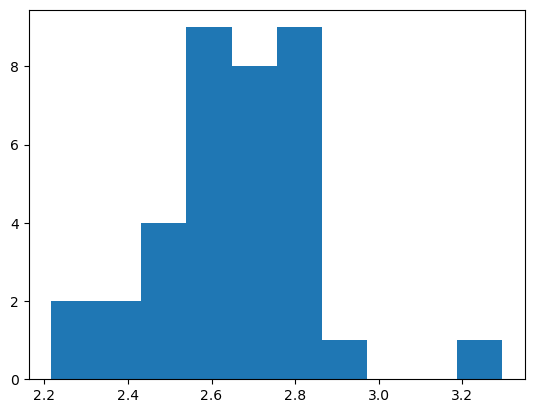

In [9]:
sliding_window_decoder(N=144, p=0.005, num_repeat=4, W=3, F=1, num_shots=5000, max_iter=8, method=1, z_basis=True)
plt.hist([x*1000 for x in decoding_time]) # convert s to ms

# Here I only gather the runtime for samples that GDG failed to converge on.
# Theoretically, they have the worst-case runtime.
# One can also gather runtime for every sample, but will find a few samples running for very long.
# This is an OS issue, and please refer to this series of blog post 
# https://shuhaowu.com/blog/2022/01-linux-rt-appdev-part1.html
# for better latency control.

In [3]:
sliding_window_decoder(N=288, p=0.005, num_repeat=6, W=4, F=1, num_shots=20000, max_iter=16, method=1, z_basis=True,
                       max_step=60, max_tree_depth=4, max_side_depth=20, max_side_branch_step=40)

# Using OSD in the last window **only** can improve performance, an issue I mentioned in Appendix E.
# The improvement is only prominent for N=288 and small num_repeat.

prior for noisy syndrome 0.04572241379526658
Stim: noise sampling for 20000 shots, elapsed time: 0.05161724401114043
Window 0, average weight 35.09255
Window 0, flagged Errors: 1/20000
Window 1, average weight 35.5825
Window 1, flagged Errors: 5/20000
Window 2, average weight 35.70345
Window 2, flagged Errors: 4/20000
Window 3, average weight 27.96595
Window 3, flagged Errors: 129/20000
Elapsed time: 601.918304175997
last round osd False
Overall Flagged Errors: 129/20000
Logical Errors: 137/20000
logical error per round: 0.0011449388806175076
Window 3, average weight 27.9406
Window 3, flagged Errors: 9/20000
Elapsed time: 1083.1758172359987
last round osd True
Overall Flagged Errors: 9/20000
Logical Errors: 85/20000
logical error per round: 0.0007095909412510037
